In [1]:
from statcan_wds import previewDimensions, getTableData
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def pivot_column(df, index, col, value_col, aggfunc="first"):
    wide = (
        df.pivot_table(
            index=index,
            columns=col,
            values=value_col,
            aggfunc=aggfunc
        )
        .reset_index()
        .rename_axis(None, axis=1)
    )
    return wide

### Foreign Exchange Rates (USD/CAD and EUR/CAD)
- [Legacy FX data](https://www.bankofcanada.ca/rates/exchange/legacy-noon-and-closing-rates/) (prior to 2017)
- [Current FX data](https://www.bankofcanada.ca/rates/exchange/monthly-exchange-rates/) (2017 and later)

In [3]:
def get_legacy_fx_data(codes, startDate="2000-01-01", endDate="2016-12-31"):
    if codes is None:
        return None
    
    fx_df = None
    for code in codes:
        fx_url = f"https://www.bankofcanada.ca/valet/observations/{code}/csv?start_date={startDate}&end_date={endDate}"
        df = pd.read_csv(fx_url, skiprows=8)
        fx_df = fx_df.merge(df, on="date", how="inner") if fx_df is not None else df
    fx_df.columns = [codes.get(c, c) for c in fx_df.columns]
    return fx_df

In [4]:
def get_current_fx_data(codes, startDate="2017-01-01", skiprows=39):
    if codes is None:
        return None
    
    fx_url = f"https://www.bankofcanada.ca/valet/observations/group/FX_RATES_MONTHLY/csv?start_date={startDate}"
    df = pd.read_csv(fx_url, skiprows=skiprows)
    df = df[["date"] + list(codes.keys())]
    df.columns = [codes.get(c, c) for c in df.columns]
    return df

In [5]:
def get_fx_data(codes, startDate, endDate):
    legacy = get_legacy_fx_data(codes.get("legacy"), startDate, endDate)
    current = get_current_fx_data(codes.get("current"), startDate)
    fx_df = pd.concat([legacy, current], ignore_index=False)
    fx_df["date"] = pd.to_datetime(fx_df["date"])
    return fx_df

In [6]:
fx_codes = {
    "legacy": {"IEXM0102_AVG": "USD/CAD", "EUROCAM01": "EUR/CAD"},
    "current": {"FXMUSDCAD": "USD/CAD", "FXMEURCAD": "EUR/CAD"}
}

In [7]:
fx_data = get_fx_data(codes=fx_codes, startDate="2000-01-01", endDate="2017-01-01")

In [8]:
fx_data.head()

,date,USD/CAD,EUR/CAD
0,2000-01-01,1.448170,1.4676
1,2000-02-01,1.450300,1.4273
2,2000-03-01,1.460283,1.4088
3,2000-04-01,1.468042,1.3881
4,2000-05-01,1.494864,1.3567


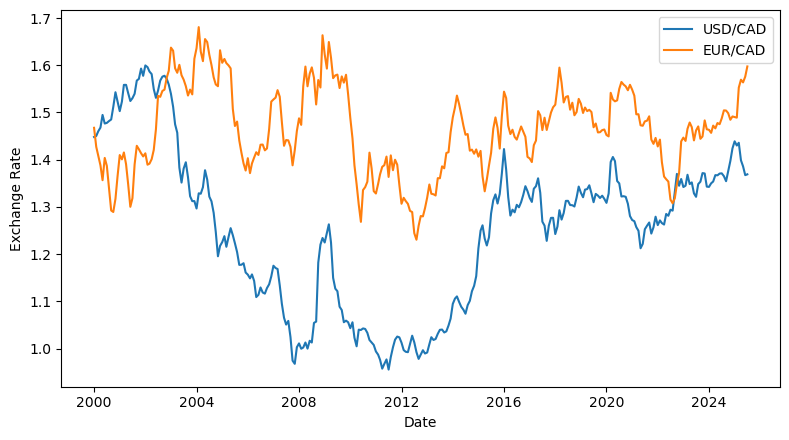

In [9]:
plt.figure(figsize=(8,4.5))
sns.lineplot(data=fx_data, x="date", y="USD/CAD", label="USD/CAD")
sns.lineplot(data=fx_data, x="date", y="EUR/CAD", label="EUR/CAD")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.tight_layout()

### Labour Force Characteristics (Employment and Unemployment Rates)
- SatCan Table: `14-10-0287-03`

In [176]:
def get_labour_force_data(specs, startDate="2000-01-01", endDate="2025-12-31"):
    PID = 14100287
    raw_df = getTableData(pid=PID, series_specs=specs, startRefPeriod=startDate, endRefPeriod=endDate)
    df = pivot_column(df=raw_df, index=["Geography", "REF_DATE"], col="Labour force characteristics", value_col="VALUE")
    df = df.rename(columns={"REF_DATE": "date"})
    df["date"] = pd.to_datetime(df["date"])
    return df

In [11]:
previewDimensions(pid=14100287, target="names")

{'Geography': 1,
 'Labour force characteristics': 2,
 'Gender': 3,
 'Age group': 4,
 'Statistics': 5,
 'Data type': 6}

In [12]:
lfs_specs = [
    {"Geography": ["Canada"]},
    {"Labour force characteristics": ["Employment rate", "Unemployment rate"]},
    {"Data type": ["Seasonally adjusted"]},
    {"Statistics": ["Estimate"]},
    {"Gender": ["Total - Gender"]},
    {"Age group": "15 years and over"}
]

In [177]:
labour_force_data = get_labour_force_data(specs=lfs_specs, startDate="2000-01-01", endDate="2025-12-31")

In [14]:
labour_force_data.head()

,Geography,date,Employment rate,Unemployment rate
0,Canada,2000-01-01,61.2,6.8
1,Canada,2000-02-01,61.2,6.9
2,Canada,2000-03-01,61.3,6.9
3,Canada,2000-04-01,61.3,6.7
4,Canada,2000-05-01,61.3,6.6


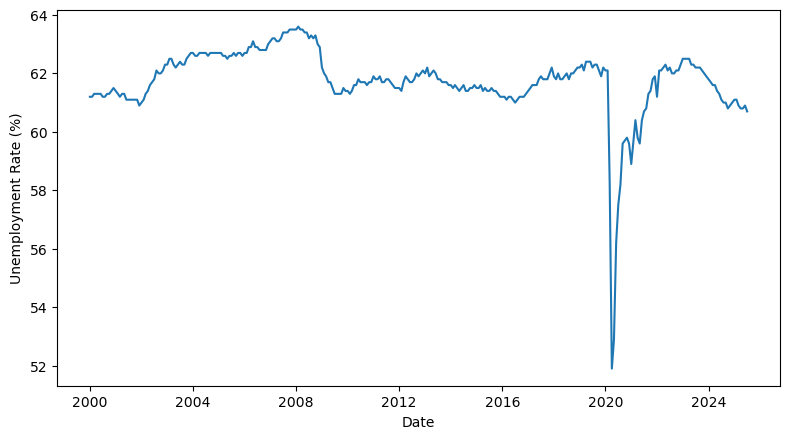

In [171]:
plt.figure(figsize=(8,4.5))
sns.lineplot(data=labour_force_data, x="date", y="Employment rate")
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.tight_layout()

### Gasoline and Fuel Prices
- StatCan Table: `18-10-0001-01`

In [175]:
def get_fuel_price_data(specs, startDate="2000-01-01", endDate="2025-12-31"):
    PID = 18100001
    raw_df = getTableData(pid=PID, series_specs=specs, startRefPeriod=startDate, endRefPeriod=endDate)
    df = pivot_column(df=raw_df, index=["Geography", "REF_DATE"], col="Type of fuel", value_col="VALUE")
    df = df.rename(columns={
        "REF_DATE": "date", 
        "Regular unleaded gasoline at self service filling stations": "Gasoline price",
        "Diesel fuel at self service filling stations": "Diesel price"
    })
    df["date"] = pd.to_datetime(df["date"])
    df = df.groupby(["date"], as_index=False).agg({"Gasoline price": "mean", "Diesel price": "mean"})
    df["Geography"] = "Canada"
    return df

In [17]:
previewDimensions(pid=18100001, target="names")

{'Geography': 1, 'Type of fuel': 2}

In [18]:
previewDimensions(pid=18100001, target="values", dimName="Type of fuel")

{'Regular unleaded gasoline at full service filling stations': 1,
 'Regular unleaded gasoline at self service filling stations': 2,
 'Premium unleaded gasoline at full service filling stations': 3,
 'Premium unleaded gasoline at self service filling stations': 4,
 'Diesel fuel at full service filling stations': 5,
 'Diesel fuel at self service filling stations': 6,
 'Household heating fuel': 7}

In [25]:
fuel_geo = previewDimensions(pid=18100001, target="values", dimName="Geography")

In [57]:
fuel_price_specs = [
    {"Geography": [g for g in fuel_geo if g != "Canada"]},
    {"Type of fuel": ["Regular unleaded gasoline at self service filling stations", "Diesel fuel at self service filling stations"]}
]

In [178]:
fueld_price_data = get_fuel_price_data(specs=fuel_price_specs, startDate="2000-01-01", endDate="2025-12-31")

In [179]:
fueld_price_data.head()

,date,Gasoline price,Diesel price,Geography
0,2000-01-01,65.427778,60.135714,Canada
1,2000-02-01,67.144444,65.207143,Canada
2,2000-03-01,72.661111,65.121429,Canada
3,2000-04-01,70.038889,65.514286,Canada
4,2000-05-01,70.911111,64.628571,Canada


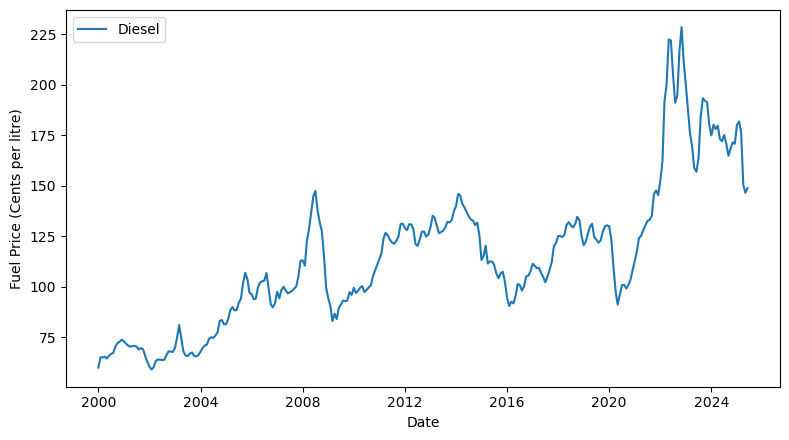

In [210]:
plt.figure(figsize=(8,4.5))
sns.lineplot(data=fueld_price_data, x="date", y="Diesel price", label="Diesel")
plt.xlabel("Date")
plt.ylabel("Fuel Price (Cents per litre)")
plt.legend()
plt.tight_layout()

### International Merchandise Trade
- StatCan Table: `12-10-0128-01` (Archived - up to 2023)
- StatCan Table: `12-10-0168-01` (Current)

In [206]:
def get_trade_data(specs, startDate="2000-01-01", endDate="2025-12-31"):
    CURRENT_PID = 12100168
    ARCHIVED_PID = 12100128
    # Helper function
    def fetch_data(specs, pid, startDate, endDate):
        raw_df = getTableData(pid=pid, series_specs=specs, startRefPeriod=startDate, endRefPeriod=endDate)
        df = pivot_column(df=raw_df, index=["Geography", "REF_DATE"], col="Trade", value_col="VALUE")
        df = df.rename(columns={"REF_DATE": "date"})
        df["date"] = pd.to_datetime(df["date"])
        return df

    archived = None
    current = None
    if pd.to_datetime(startDate) < pd.to_datetime("2017-01-01"):
        date = str(min(pd.to_datetime(endDate),  pd.to_datetime("2016-12-31")).date())
        archived = fetch_data(specs, pid=ARCHIVED_PID, startDate=startDate, endDate=date)
    if pd.to_datetime(endDate) >= pd.to_datetime("2017-01-01"):
        date = str(max(pd.to_datetime(startDate), pd.to_datetime("2017-01-01")).date())
        current = fetch_data(specs, pid=CURRENT_PID, startDate=date, endDate=endDate)
    
    trade_df = pd.concat([archived, current], ignore_index=True)
    
    return trade_df

In [195]:
previewDimensions(pid=12100168, target="names")

{'Geography': 1,
 'Trade': 2,
 'Basis': 3,
 'Seasonal adjustment': 4,
 'Index': 5,
 'Weighting': 6,
 'North American Product Classification System (NAPCS)': 7}

In [197]:
trade_specs = [
    {"Geography": ["Canada"]},
    {"Trade": ["Import", "Export"]},
    {"Basis": ["Customs"]},
    {"Seasonal adjustment": ["Seasonally adjusted"]},
    {"Index": ["Price index"]},
    {"Weighting": ["Laspeyres fixed weighted"]},
    {"North American Product Classification System (NAPCS)": ["Farm, fishing and intermediate food products"]}
]

In [207]:
trade_data = get_trade_data(specs=trade_specs, startDate="2000-01-01", endDate="2025-12-31")

In [208]:
trade_data.head()

,Geography,date,Export,Import
0,Canada,2000-01-01,62.9,75.6
1,Canada,2000-02-01,63.1,76.4
2,Canada,2000-03-01,63.4,76.9
3,Canada,2000-04-01,64.0,78.0
4,Canada,2000-05-01,64.9,78.7


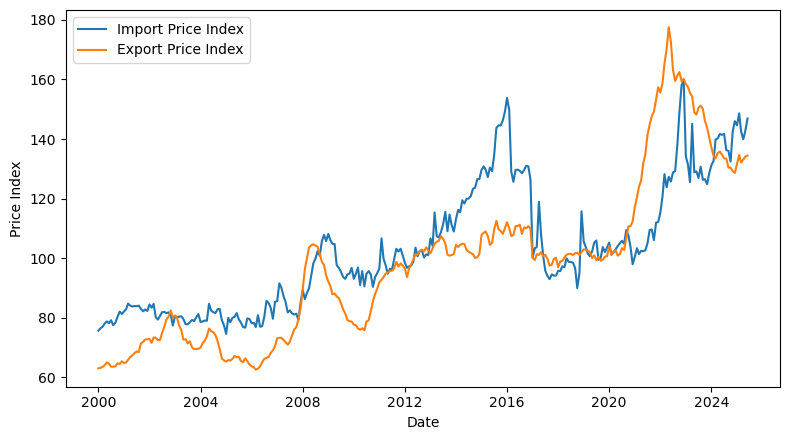

In [209]:
plt.figure(figsize=(8,4.5))
sns.lineplot(data=trade_data, x="date", y="Import", label="Import Price Index")
sns.lineplot(data=trade_data, x="date", y="Export", label="Export Price Index")
plt.xlabel("Date")
plt.ylabel("Price Index")
plt.legend()
plt.tight_layout()

### Food Consumer Price Index (Seasonally adjusted)
- StatCan Table: `18-10-0006-01`

In [215]:
def get_cpi_data(specs, startDate="2000-01-01", endDate="2025-12-31"):
    PID = 18100006
    raw_df = getTableData(pid=PID, series_specs=specs, startRefPeriod=startDate, endRefPeriod=endDate)
    df = pivot_column(df=raw_df, index=["Geography", "REF_DATE"], col="Products and product groups", value_col="VALUE")
    df = df.rename(columns={"REF_DATE": "date"})
    df["date"] = pd.to_datetime(df["date"])
    return df

In [142]:
previewDimensions(pid=18100006, target="names")

{'Geography': 1, 'Products and product groups': 2}

In [211]:
cpi_specs = [
    {"Geography": ["Canada"]},
    {"Products and product groups": ["Food"]}
]

In [216]:
food_cpi_data = get_cpi_data(specs=cpi_specs, startDate="2000-01-01", endDate="2025-12-31")

In [146]:
food_cpi_data.head()

,Geography,date,Food
0,Canada,2000-01-01,91.8
1,Canada,2000-02-01,91.8
2,Canada,2000-03-01,92.1
3,Canada,2000-04-01,92.3
4,Canada,2000-05-01,92.8


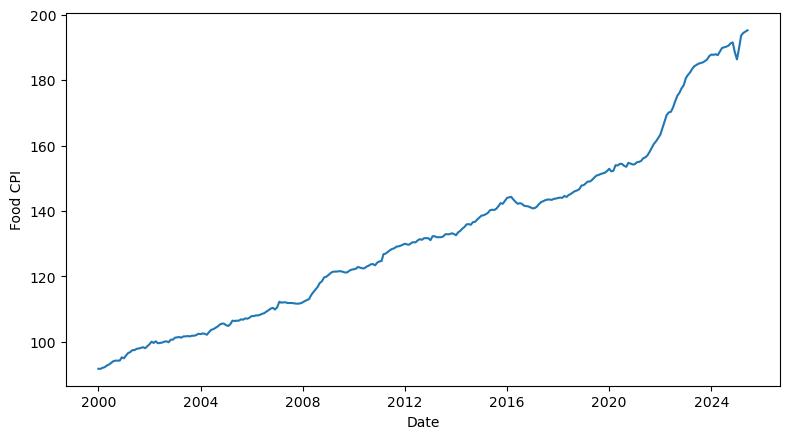

In [148]:
plt.figure(figsize=(8,4.5))
sns.lineplot(data=food_cpi_data, x="date", y="Food")
plt.xlabel("Date")
plt.ylabel("Food CPI")
plt.tight_layout()